In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques

Un modèle simple et fréquemment utilisé pour décrire la performance d'une connexion de réseau consiste à supposer que le temps d'envoi T pour un message dépend principalement de sa taille S (nombre d'octets) et de deux grandeurs propres à la connexion : la latence L (en secondes) et la capacité C (en octets/seconde). La relation entre ces quatre quantités est ___T(S) = L + S/C___. Ce modèle néglige un grand nombre de détails. D'une part, L et C dépendent bien sûr du protocole de communication choisi mais aussi dans une certaine mesure de S. D'autre part, la mesure de T(S) comporte en général une forte composante aléatoire. Nous nous intéressons ici au temps moyen qu'il faut pour envoyer un message d'une taille donnée.

Nous allons estimer L et C à partir d'une série d'observations de T pour des valeurs différentes de S. Notre analyse commence avec la lectures des données brutes, disponibles pour deux connexions différentes, qui ont été obtenues avec l'outil ping.

Les deux fichiers contiennent la sortie brute de l'outil ping qui a été exécuté dans une boucle en variant de façon aléatoire la taille du message. Chaque ligne a la forme suivante:

__[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms__

Au début, entre crochet, nous trouvons la date à laquelle la mesure a été prise, exprimée en secondes depuis le 1er janvier 1970. La taille du message en octets est donnée juste après, suivie par le nom de la machine cible et son adresse IP, qui sont normalement identiques pour toutes les lignes à l'intérieur d'un jeu de données. À la fin de la ligne, nous trouvons le temps d'envoi (aller-retour) en millisecondes. Les autres indications, icmp_seq et ttl, n'ont pas d'importance pour notre analyse

# 1er jeu de données

Nous commencons par travailler sur le 1er jeu de données qui examine une connexion courte à l'intérieur d'un campus.

Nous lisons le fichiers et récupérons les données intérésantes : la date (convertie de secondes à année-mois-jour), la taille des messages, la machine cible et les adresses IP. Nous gardons aussi le temps de transmission, si celui-ci n'est pas présent la ligne n'est pas gardée. Les données sont ensuite triées en fonction de la date.

In [2]:
fichier_1 = open("liglab2.log").readlines()
fichier_1 = [l for l in fichier_1 if 'time' in l]
raw_data = [l.split(' ') for l in fichier_1]
data = [ [d[0][1:-1], int(d[1]), d[4], d[5][1:-2], float(d[8].split('=')[1])] for d in raw_data]
data = pd.DataFrame(data, columns=['date', 'taille', 'cible', 'IP', 'temps'])
data['date'] = pd.to_datetime(data['date'], unit='s')
sorted_data = data.set_index('date').sort_index()
#sorted_data

Nous vérfions que toutes les données proviennents de la même machine cible. Ici pas de problème.

In [3]:
sorted_data['cible'].value_counts()

lig-publig.imag.fr    44036
Name: cible, dtype: int64

In [4]:
sorted_data['IP'].value_counts()

129.88.11.7    44036
Name: IP, dtype: int64

## 1 ) Temps de transmission au cours du temps

Nous regardons ici le temps de temps transmission. (Le notebook plante lorsque trop de données sont affichées en même temps dans les graphiques)

Text(0,0.5,'Temps de transmission (ms)')

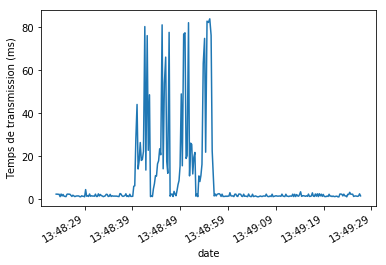

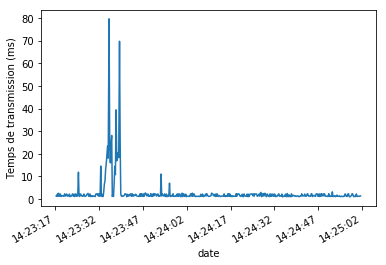

In [5]:
sorted_data['temps'].iloc[100:400].plot()
plt.ylabel("Temps de transmission (ms)")
plt.figure()
sorted_data['temps'].iloc[10000:10500].plot()
plt.ylabel("Temps de transmission (ms)")

On observe des pics du temps de transmission qui ne correspondent pas à un phénomène àléatoire utilisé pour définir la tailles des messages envoyés. La taille des messages n'explique donc pas à elle seule le temps de transmission.

## 2) Temps de transmission en fonction de la tailles des messages

Nous regardons maintenant le temps de transmission en fonction de la taille des messages

Text(0,0.5,'Temps de transmission (ms)')

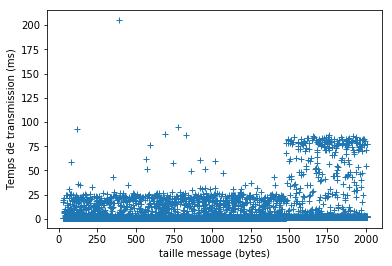

In [6]:
plt.plot(sorted_data['taille'].iloc[:10000], sorted_data['temps'].iloc[:10000], '+')
plt.xlabel("taille message (bytes)")
plt.ylabel("Temps de transmission (ms)")

Nous changons l'échelle de l'axe des ordonnées.

(0, 3)

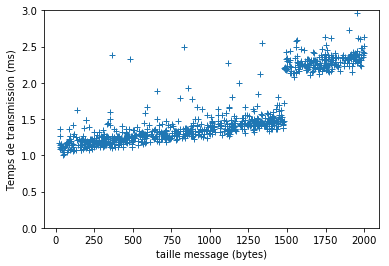

In [24]:
plt.plot(sorted_data['taille'].iloc[10000:11000], sorted_data['temps'].iloc[10000:11000], '+')
plt.xlabel("taille message (bytes)")
plt.ylabel("Temps de transmission (ms)")
plt.ylim([0,3])

Nous remarquons une rupture dans le temps de transmission à appartir de 1500 bytes. Nous étudierons séparément les messages de plus de 1500 bytes et ceux de moins de 1500 bytes.

In [8]:
limite = 1500

## 3) Estimation de L et C

Estimons maintenant L et C sur les deux groupes de messages à l'aide d'une régression linéaire.
Nous commençons par les messages de moins de 1500 bytes.

In [44]:
from sklearn import linear_model
model = linear_model.LinearRegression()
X = sorted_data[sorted_data['taille']<limite].taille.iloc[:].values.reshape(-1, 1)
y = sorted_data[sorted_data['taille']<limite].temps.iloc[:].values.reshape(-1, 1)
results = model.fit(X, y)

Nous rappelons que  T(S) = L + S/C donc : 

In [45]:
L_m_limite = float(results.intercept_)
C_m_limite = float(1/ results.coef_)
print("L = ", L_m_limite)
print("C = ", C_m_limite)

L =  3.128080832670244
C =  1620.0508339606433


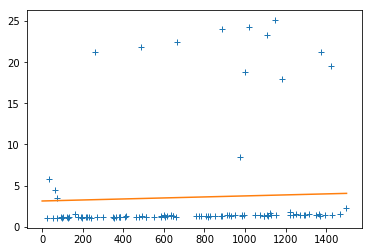

In [46]:
plt.plot(X[:100],y[:100],'+')
x = np.linspace(0,limite, 100)
plt.plot(x, L_m_limite + x/C_m_limite)

Même excercice avec les messages de plus de 1500 bytes

L =  4.920748136138777
C =  359.78126382483623


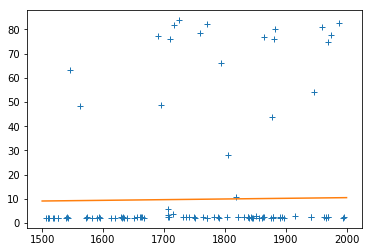

In [47]:
from sklearn import linear_model
model = linear_model.LinearRegression()
X = sorted_data[sorted_data['taille']>limite].taille.iloc[:].values.reshape(-1, 1)
y = sorted_data[sorted_data['taille']>limite].temps.iloc[:].values.reshape(-1, 1)
results = model.fit(X, y)
L_p_limite = float(results.intercept_)
C_p_limite = float(1/ results.coef_)
print("L = ", L_p_limite)
print("C = ", C_p_limite)
plt.plot(X[:100],y[:100],'+')
x = np.linspace(limite,2000, 100)
plt.plot(x, L_p_limite + x/C_p_limite)

## Conclusion

In [ ]:
plt.plot(sorted_data['taille'].iloc[10000:15000], sorted_data['temps'].iloc[10000:15000], '+')
x = np.linspace(0,limite, 100)
plt.plot(x, L_m_limite + x/C_m_limite)
x = np.linspace(limite,2000, 100)
plt.plot(x, L_p_limite + x/C_p_limite)
plt.xlabel("taille message (bytes)")
plt.ylabel("Temps de transmission (ms)")
plt.ylim([0,20])